In [87]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from pandarallel import pandarallel
import os

import tensorflow_hub as hub
import chardet
from tensorflow.keras.preprocessing.text import text_to_word_sequence
import matplotlib.pyplot as plt

import mysql.connector
from mysql.connector import Error
import yfinance as yf
import sqlalchemy as db
from sqlalchemy import text, inspect, insert

In [91]:
cols = ['sentiment', 'id', 'created_at', 'query_string', 'username', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='cp437', header=None, names=cols)

In [92]:
df.sentiment.value_counts()

0    800000
4    800000
Name: sentiment, dtype: int64

In [93]:
df['sentiment'] = df['sentiment'].replace(4,1)

Dropping 4 unimportant columns

In [94]:
df = df.drop(['id', 'created_at', 'query_string', 'username'], axis=1)

In [96]:
df['raw_length'] = [len(text) for text in df.text]

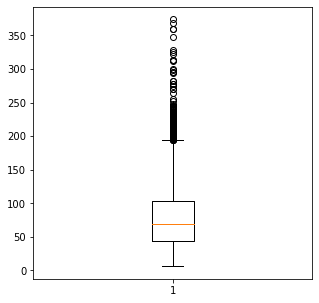

In [97]:
fig, ax = plt.subplots(figsize=(5,5))
plt.boxplot(df.raw_length)
plt.show()

Twitter's character limit is 140. However, from the above plot, there are many tweets with more than 140 characters long, hence need for preprocessing and cleaning.

In [98]:
df[df.raw_length > 140].head(10)

,sentiment,text,raw_length
213,0,Awwh babs... you look so sad underneith that shop entrance of &quot;Yesterday's Musik&quot; O-: I like the look of the new transformer movie,142
226,0,Tuesday∩┐╜ll start with reflection ∩┐╜n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers,141
279,0,Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly.,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down,145
400,0,"#3 woke up and was having an accident - &quot;It's pushing, it's pushing!&quot; he was crying because he couldn't stop from wetting his pants.",144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, &amp; it iz FAIL. I got all Drano on its ass, &amp; iz STILL NOT DRAINING. I wanna shower, dangit!!",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quot;Win a Date With Tad Hamilton&quot;... oh gawwd my life flashed forward to when I'm 40 with my 75 cats",150
747,0,Have an invite for &quot;Healthy Dining&quot; session at Ashok Hotel today with Exec Chef R.Chopra but damn workload - will have to skip it!,141
957,0,Damnit I was really digging this season of Reaper http://www.tv.com/story/13720.html?ref_story_id=13720&amp;ref_type=1101&amp;ref_name=story,141
1064,0,Why do I keep looking...I know that what I read is gonna hurt but I still look! I guess it's just a girl thing &amp; I need to get over him.,141


It can be seen that HTML encoding has not been converted to text and thus appearing in the text field as '&amp' and '&quot' etc. This requires HTML decoding. We use BeautifulSoup

We also need to get rid of @ mention. In the context of this study, @mention does not add value because the username mentioned does not add value to the sentiment of each tweet text. 

We also need to remove URL links, as well as UTF

Text cleaning and preprocessing function 

In [99]:
from lib2to3.pgen2 import token
from turtle import done
from nltk.tokenize import word_tokenize
import re
import nltk
from nltk.stem import WordNetLemmatizer
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
nltk.download('stopwords')
import contractions
from nltk.probability import FreqDist


#Below is the format to remove all @mentions and URL links
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"


stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
tokenizer = Tokenizer()
fdist = FreqDist()


def text_cleaner(text):

    tokens = []
    text = text.lower()
    #Using beautifulSoup for HTML decoding to get rid of '&amp' and '&quot' etc
    bs = BeautifulSoup(text, 'lxml')
    text = bs.get_text()
    
    #souped contains HTML decoded string
    #We then remove @mentions and URL links 
    text = re.sub(urlPattern, '<url>', text)
    text = re.sub(userPattern, '<user>', text)
    text = re.sub(sequencePattern, seqReplacePattern, text)
    text = re.sub(r'<3', '<heart>', text)
    text = re.sub(smileemoji, '<smile>', text)
    text = re.sub(sademoji, '<sadface>', text)
    text = re.sub(neutralemoji, '<neutralface>', text)
    text = re.sub(lolemoji, '<lolface>', text)  
    

    #Replace all contractions in full forms e.g. he'll to he will
    text = contractions.fix(text)

    #remove all non letters
    text = re.sub("[^a-zA-Z<>]", " ", text)
    words = text.split(" ")
    for word in words:
        if word not in stop_words:
            tokens.append(lemmatizer.lemmatize(word))
            fdist[word] += 1
    
    #replace 3 or more consecutive letters by 2 letter

    text = (" ").join(tokens)
    text = re.sub(r'/', ' / ', text)
    return text
   

    

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/seunghwanchoi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [101]:
import tqdm
pandarallel.initialize()
df['preprocessed'] = df['text'].parallel_apply(text_cleaner)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


/Users/seunghwanchoi/miniforge3/envs/tf-test/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/seunghwanchoi/miniforge3/envs/tf-test/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/seunghwanchoi/miniforge3/envs/tf-test/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(
/Users/seunghwanchoi/miniforge3/envs/tf-test/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open 

In [102]:
count = 0
for row in df.itertuples():
    print("Text: ", row[2])
    print("Processed: ", row[4])
    count +=1
    if count > 10:
        break

Text:  @switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Processed:  <user> <url>   aww  that is a bummer   you shoulda got david carr of third day to do it  <smile>
Text:  is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!
Processed:  is upset that he cannot update his facebook by texting it   and might cry as a result  school today also  blah 
Text:  @Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds
Processed:  <user> i dived many times for the ball  managed to save      the rest go out of bounds
Text:  my whole body feels itchy and like its on fire 
Processed:  my whole body feels itchy and like its on fire 
Text:  @nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. 
Processed:  <user> no  it is not behaving at all  i am mad  why am i here  because i cannot see

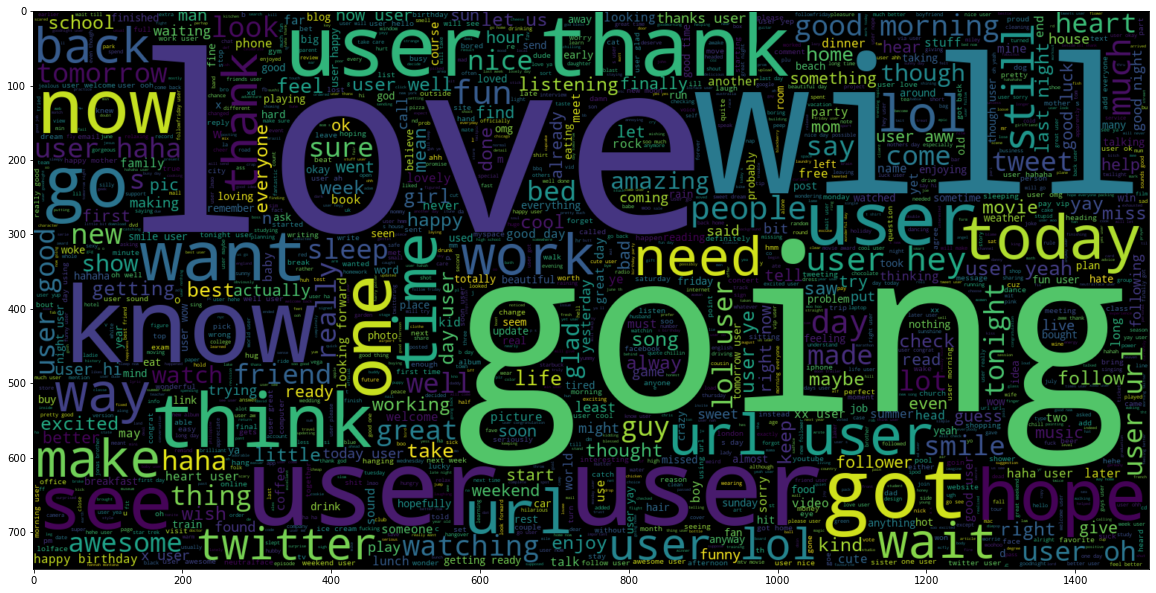

In [109]:
from wordcloud import WordCloud

plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 1500 , width = 1500 , height = 750).generate(" ".join(df[df.sentiment == 1].preprocessed))
plt.imshow(wc , interpolation = 'bilinear')

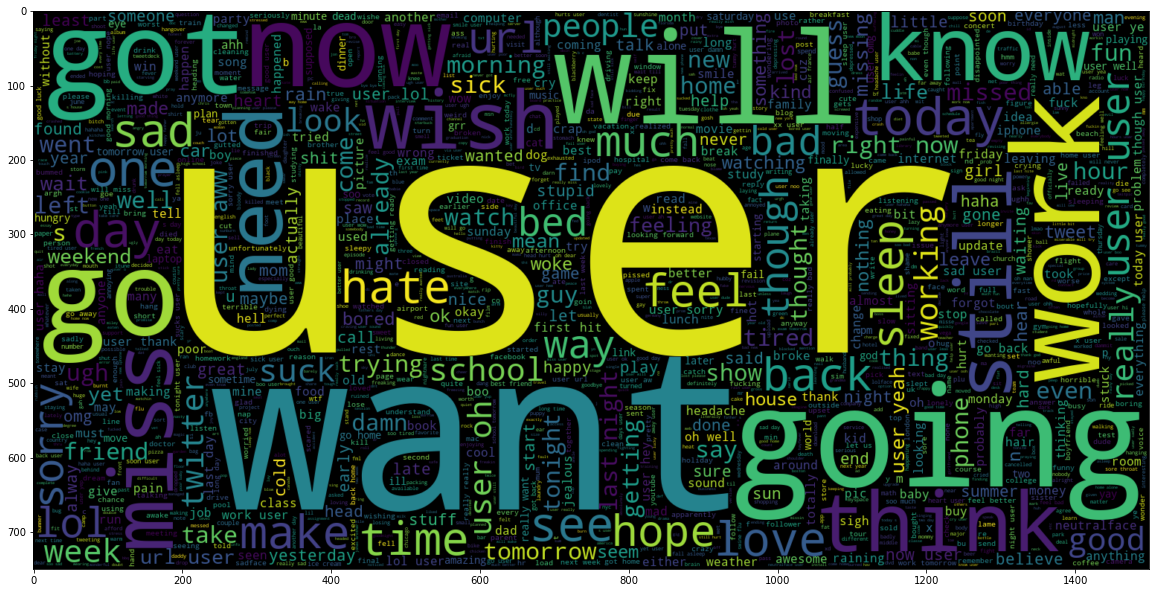

In [110]:
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 1500 , width = 1500 , height = 750).generate(" ".join(df[df.sentiment == 0].preprocessed))
plt.imshow(wc , interpolation = 'bilinear')

In [111]:
from sklearn.model_selection import train_test_split

X_data, Y_data = np.array(df['preprocessed']), np.array(df['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, shuffle=True,
                                                    random_state=42)

Data split complete


Creating word embiddings using word2vec model

In [113]:
from gensim.models import Word2Vec

Embedding_dimensions = 150

Word2Vec_train_data = list(map(lambda x: x.split(), X_train))

word2vec_model = Word2Vec(Word2Vec_train_data,
                          vector_size = Embedding_dimensions,
                          workers = 10,
                          min_count = 4)

print("Vocabulary Length: ", len(word2vec_model.wv.key_to_index))

Vocabulary Length:  51764


In [114]:
input_length = 200

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_length = 60000
tokenizer = Tokenizer(filters="", lower= False, oov_token="<oov>")
tokenizer.fit_on_texts(X_data)
tokenizer.num_words = vocab_length
print("Tokenizer vocab length: ", tokenizer.num_words)

Tokenizer vocab length:  60000


Padding

In [115]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=input_length)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=input_length)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)

X_train shape:  (1280000, 200)
X_test shape:  (320000, 200)


In [116]:
embedding_matrix = np.zeros((vocab_length, Embedding_dimensions))

dict = tokenizer.word_index.items()
print(tokenizer.num_words)

for word, token in tokenizer.word_index.items():
    print(word, token)
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[token] = word2vec_model.wv.__getitem__(word)
    if token == 59999:
        break

print("Embedding Matrix Shape: ", embedding_matrix.shape)

60000
<oov> 1
i 2
<user> 3
to 4
the 5
is 6
a 7
you 8
my 9
it 10
and 11
not 12
am 13
in 14
for 15
of 16
have 17
that 18
on 19
me 20
so 21
do 22
but 23
are 24
just 25
with 26
be 27
at 28
was 29
will 30
this 31
now 32
good 33
up 34
going 35
day 36
all 37
out 38
get 39
like 40
no 41
<url> 42
go 43
got 44
today 45
too 46
love 47
cannot 48
your 49
s 50
work 51
we 52
what 53
lol 54
want 55
time 56
back 57
know 58
from 59
one 60
did 61
about 62
really 63
had 64
can 65
there 66
see 67
some 68
how 69
its 70
if 71
night 72
they 73
still 74
well 75
thanks 76
would 77
new 78
think 79
as 80
home 81
oh 82
when 83
he 84
here 85
more 86
off 87
much 88
miss 89
need 90
last 91
tomorrow 92
an 93
has 94
then 95
morning 96
hope 97
been 98
great 99
twitter 100
or 101
though 102
haha 103
she 104
her 105
again 106
by 107
feel 108
way 109
sad 110
fun 111
could 112
sleep 113
why 114
wish 115
only 116
right 117
them 118
bad 119
happy 120
very 121
sorry 122
tonight 123
come 124
make 125
should 126
getting 127
peop

In [124]:
from gc import callbacks
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D

def get_model():
    embedding_layer = Embedding(input_dim = vocab_length,
                                output_dim = Embedding_dimensions,
                                weights = [embedding_matrix],
                                input_length = input_length,
                                trainable = False)
    
    model = Sequential([
        embedding_layer,
        Bidirectional(LSTM(100, dropout=0.2, return_sequences=True)),
        Bidirectional(LSTM(100, dropout=0.2, return_sequences=True)),
        GlobalMaxPool1D(),
        Dense(16, activation= 'relu'),
        Dense(1, activation='sigmoid'),
    ],
    name = "Sentiment_Model"
    )
    return model



In [125]:
train_model = get_model()
train_model.summary()

Model: "Sentiment_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 150)          9000000   
                                                                 
 bidirectional_6 (Bidirectio  (None, 200, 200)         200800    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 200, 200)         240800    
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 200)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 16)                3216      
                                                   

In [121]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))

callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
             EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]
            #  lr_schedule]


In [126]:
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
train_model.compile(loss='binary_crossentropy', optimizer = optimizer, metrics=['accuracy'])

In [127]:
history = train_model.fit(
    X_train, y_train,
    batch_size=256,
    epochs=12,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/12


2022-10-23 18:21:10.361474: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:21:11.372447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:21:11.539435: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:21:12.397225: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:21:12.412471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:21:13.054690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:21:13.060072: I tensorflow/core/grappler/optimizers/cust

4500/4500 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.7054

2022-10-23 18:53:04.003123: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:53:04.369011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:53:04.384594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:53:04.948667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-10-23 18:53:04.965085: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4500/4500 [==============================] - 1994s 441ms/step - loss: 0.5655 - accuracy: 0.7054 - val_loss: 0.5522 - val_accuracy: 0.7139
Epoch 2/12
4500/4500 [==============================] - 1974s 439ms/step - loss: 0.5600 - accuracy: 0.7084 - val_loss: 0.5401 - val_accuracy: 0.7240
Epoch 3/12
4500/4500 [==============================] - 2004s 445ms/step - loss: 0.5576 - accuracy: 0.7101 - val_loss: 0.5519 - val_accuracy: 0.7149
Epoch 4/12
4500/4500 [==============================] - 2028s 451ms/step - loss: 0.5561 - accuracy: 0.7115 - val_loss: 0.5676 - val_accuracy: 0.7021
Epoch 5/12
4500/4500 [==============================] - 1988s 442ms/step - loss: 0.5588 - accuracy: 0.7095 - val_loss: 0.5726 - val_accuracy: 0.6973
Epoch 6/12
4500/4500 [==============================] - 1994s 443ms/step - loss: 0.5558 - accuracy: 0.7124 - val_loss: 0.5578 - val_accuracy: 0.7075
Epoch 7/12
4500/4500 [==============================] - 2004s 445ms/step - loss: 0.5534 - accuracy: 0.7139 - val_loss

In [134]:
# Predicting on the Test dataset.
y_pred = train_model.predict(X_test)

# Converting prediction to reflect the sentiment predicted.
y_pred = np.where(y_pred>=0.5, 1, 0)

# Printing out the Evaluation metrics. 
# ConfusionMatrix(y_pred, y_test)

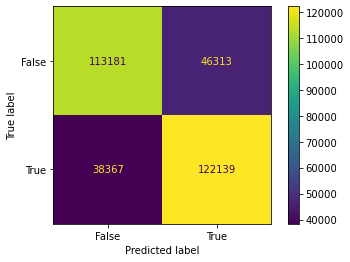

In [135]:
from sklearn import metrics
import matplotlib.pyplot as plt

conf_mat = metrics.confusion_matrix(y_test, y_pred)
conf_mat_display = metrics.ConfusionMatrixDisplay(confusion_matrix= conf_mat, display_labels= [False, True])
conf_mat_display.plot()
plt.show()

In [133]:
word2vec_model.wv.save('Word2Vec-100')
word2vec_model.wv.save_word2vec_format('Word2Vec-twitter-100-trainable')

train_model.save('Sentiment-BiLSTM')
train_model.save_weights("Model Weights/weights")

INFO:tensorflow:Assets written to: Sentiment-BiLSTM/assets


INFO:tensorflow:Assets written to: Sentiment-BiLSTM/assets
